In [1]:
%reset

# 1. Imports

In [1]:
import mne
import time

import custom_modules.file_handling as  fh
import custom_modules.classification_ptu as clas

import importlib
importlib.reload(clas)
importlib.reload(fh)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Constants

In [4]:
data_path = 'D:/Diplomarbeit_data/eeg/'
# subjects = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A10']
subjects = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A09', 'A10']
trial_type_markers = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l']

mne.set_log_level('WARNING') #'INFO' 'WARNING'

# 3. Classification

## 3.1. Cue-aligned

In [18]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_cue_aligned', dst_fldr='2023_03_22_epoched_cue_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Classifying cue-aligned for subject {subject}')

    ### Distance
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=6, loo=True)

    ### Direction
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=6, loo=True)

    ### Direction short
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=6, loo=True)

    ### Direction long
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=6, loo=True)

    ### Position
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=6, loo=True)


print(f'Finished classifying, took me {round(time.time() - start)} seconds...')


Classifying cue-aligned for subject A01
Classifying cue-aligned for subject A02
Classifying cue-aligned for subject A03
Classifying cue-aligned for subject A04
Classifying cue-aligned for subject A05
Classifying cue-aligned for subject A06
Classifying cue-aligned for subject A07
Classifying cue-aligned for subject A08
Classifying cue-aligned for subject A09
Classifying cue-aligned for subject A10
Finished classifying, took me 11 seconds...


## 3.2. Movement-aligned

In [3]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_movement_aligned', dst_fldr='2023_03_22_epoched_movement_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Classifying movement-aligned for subject {subject}')

    ### Distance
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=6, loo=True)

    ### Direction
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=6, loo=True)

    ### Direction short
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=6, loo=True)

    ### Direction long
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=6, loo=True)

    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=6, loo=True)


print(f'Finished classifiying, took me {round(time.time() - start)} seconds...')

Classifying movement-aligned for subject A01
Measuring timestamp 60/60, shape: (250, 61)

Measuring timestamp 55/55, shape: (250, 366)
Measuring timestamp 60/55, shape: (250, 366)
Measuring timestamp 60/60, shape: (232, 61)

Measuring timestamp 55/55, shape: (232, 366)
Measuring timestamp 60/55, shape: (232, 366)
Measuring timestamp 60/60, shape: (116, 61)

Measuring timestamp 55/55, shape: (116, 366)
Measuring timestamp 60/55, shape: (116, 366)
Measuring timestamp 60/60, shape: (112, 61)

Measuring timestamp 55/55, shape: (112, 366)
Measuring timestamp 60/55, shape: (112, 366)
Measuring timestamp 60/60, shape: (140, 61)

Measuring timestamp 55/55, shape: (140, 366)
Measuring timestamp 60/55, shape: (140, 366)
Classifying movement-aligned for subject A02
Measuring timestamp 60/60, shape: (298, 61)

Measuring timestamp 55/55, shape: (298, 366)
Measuring timestamp 60/55, shape: (298, 366)
Measuring timestamp 60/60, shape: (308, 61)

Measuring timestamp 55/55, shape: (308, 366)
Measuring 

# 4. Calculate mean + confidence interval for all subjects

In [2]:
# df = pd.read_csv('dataframes/classification/classification_df.csv', index_col=0)
df = pd.read_csv('D:/Diplomarbeit_data/eeg/results/classification_df.csv', index_col=0)
# classification_df_minus_2_seconds_for_movement_aligned.csv
# Calculate CI for all subjects with the same 'N_timepoints', 'Type' and 'Condition' column for each timepoint.
cols = ['Timepoint', 'Mean_accuracy', 'Type', 'N_timepoints', 'Condition', 'Upper', 'Lower']
confidence = .95
df_mean = pd.DataFrame(columns=cols)
for type in df['Type'].unique():
    for n_timepoints in df['N_timepoints'].unique():
        for condition in df['Condition'].unique():
            print(f'{type} {condition} {n_timepoints}')
            timepoints = df[(df['Condition']==condition) & (df['N_timepoints']==n_timepoints) & (df['Type']==type)]['Timepoint'].unique()
            for tp in timepoints:
                # Get average overall subjects for each timepoint:
                accs = np.array(df[(df['Type'] == type) & (df['N_timepoints'] == n_timepoints) & (df['Condition'] == condition) & (df['Timepoint'] == tp)]['Accuracy'])
                mean = accs.mean()

                # Bootstrapping for confidence interval:
                values = [np.random.choice(accs,size=len(accs),replace=True).mean() for i in range(1000)]
                lower, upper = np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])

                df_mean.loc[len(df_mean)] = [tp, mean, type, n_timepoints, condition, upper, lower]

df_mean = df_mean.dropna()

cue-aligned distance 1
cue-aligned direction 1
cue-aligned direction_short 1
cue-aligned direction_long 1
cue-aligned position 1
cue-aligned distance 6
cue-aligned direction 6
cue-aligned direction_short 6
cue-aligned direction_long 6
cue-aligned position 6
movement_aligned distance 1
movement_aligned direction 1
movement_aligned direction_short 1
movement_aligned direction_long 1
movement_aligned position 1
movement_aligned distance 6
movement_aligned direction 6
movement_aligned direction_short 6
movement_aligned direction_long 6
movement_aligned position 6


In [5]:
df_mean = pd.read_csv('D:/Diplomarbeit_data/eeg/results/classification_means_ci.csv')

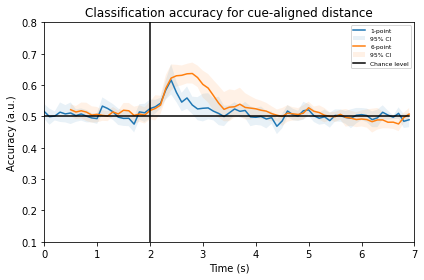

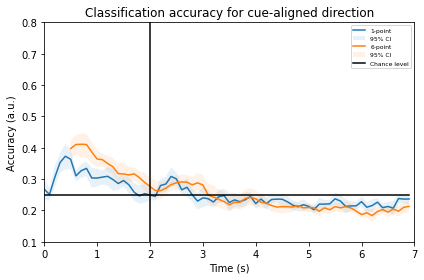

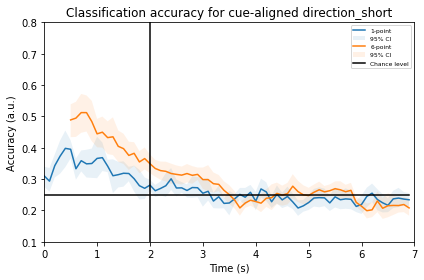

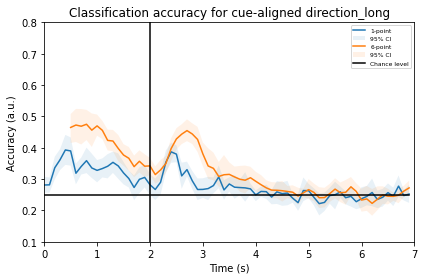

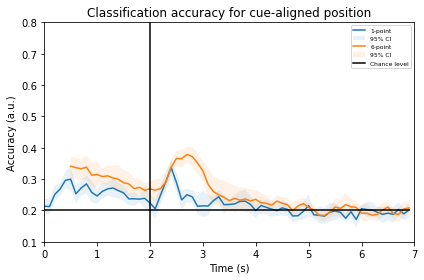

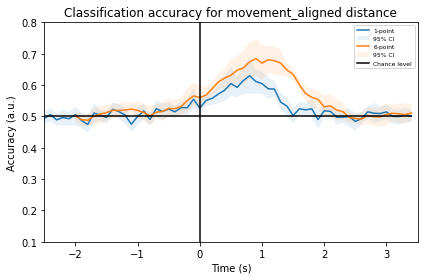

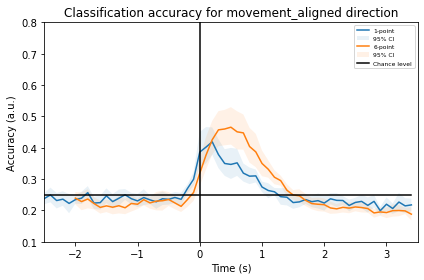

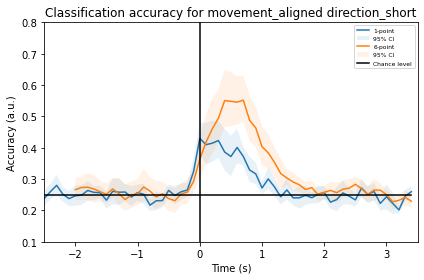

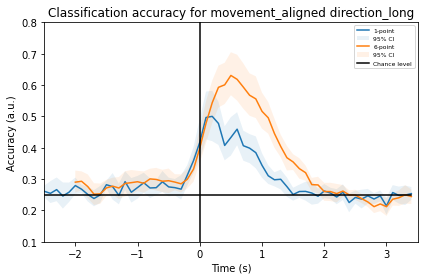

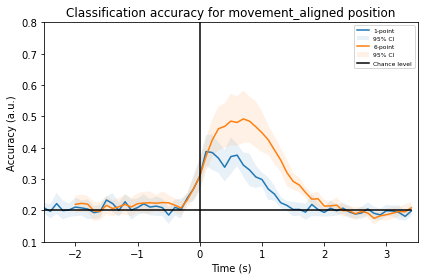

In [6]:
for type in df_mean['Type'].unique():
    for condition in df_mean['Condition'].unique():
        leg = []
        plt.figure()

        for windowed in df_mean['N_timepoints'].unique():
            # Extract tps, means and confidences to plot:
            timepoints = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Timepoint'])

            means = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Mean_accuracy'])

            uppers = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Upper'])

            lowers = list(df_mean[(df_mean['Type'] == type) & (df_mean['Condition'] == condition) & (df_mean['N_timepoints'] == windowed)]['Lower'])

            txt = f'{windowed}-point'

            leg.append(txt)
            leg.append('95% CI')

            plt.plot(timepoints, means)
            plt.fill_between(timepoints, lowers, uppers, alpha=0.1)

        if 'distance' in condition:
            plt.plot([timepoints[0]-(windowed+1)/10, timepoints[-1]], [.5, .5], color='black')
        elif 'position' in condition:
            plt.plot([timepoints[0]-(windowed+1)/10, timepoints[-1]], [.2, .2], color='black')
        else:
            plt.plot([timepoints[0]-(windowed+1)/10, timepoints[-1]], [.25, .25], color='black')

        leg.append('Chance level')
        plt.title(f'Classification accuracy for {type} {condition}')
        plt.legend(leg, loc='best', prop={'size': 6})#, bbox_to_anchor=(1, 0.5))
        plt.ylim([0.1,0.8])
        if 'cue' in type:
            plt.xlim([0,7])

            plt.plot([2,2], [0.1,0.8], color='black')
        else:
            plt.xlim([-2.5,3.5])
            plt.plot([0,0], [0.1,0.8], color='black')
        plt.xlabel('Time (s)')
        plt.ylabel('Accuracy (a.u.)')
        plt.tight_layout()
        # plt.savefig(f'{data_path}2023_04_12_classification_figs/{type}_{condition}_classification.png', dpi=400)
        plt.show()

# 5. Estimate GLM

## 5.1. Cue-aligned

In [6]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_cue_aligned', dst_fldr='2023_04_16_glm_results_cue_aligned_next_shrinkage_approach')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Fitting GLM cue-aligned for subject {subject}')

    clas.glm(src=src_path, dst=dst_path, sbj=subject)

print(f'Finished with GLM, took me {round(time.time() - start)} seconds...')



Fitting GLM cue-aligned for subject A01
Shrinkage param: 0.00651579073900898
Fitting GLM cue-aligned for subject A02
Shrinkage param: 0.005345673470727013
Fitting GLM cue-aligned for subject A03
Shrinkage param: 0.005967566762998921
Fitting GLM cue-aligned for subject A04
Shrinkage param: 0.005361782453905875
Fitting GLM cue-aligned for subject A05
Shrinkage param: 0.007482779755997901
Fitting GLM cue-aligned for subject A06
Shrinkage param: 0.0059287792854986286
Fitting GLM cue-aligned for subject A07
Shrinkage param: 0.006126397484106653
Fitting GLM cue-aligned for subject A08
Shrinkage param: 0.005987133158264003
Fitting GLM cue-aligned for subject A09
Shrinkage param: 0.005455423239377814
Fitting GLM cue-aligned for subject A10
Shrinkage param: 0.006003548272086048
Finished with GLM, took me 28 seconds...


In [7]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_04_16_glm_results_cue_aligned_next_shrinkage_approach', dst_fldr='2023_04_16_glm_results_cue_aligned_next_shrinkage_approach')

clas.coefficient_testing(src=src_path, dst=dst_path, sbj_list=subjects,two_sample=False)

In [12]:
A_load = np.load('D:/Diplomarbeit_data/eeg/2023_04_16_glm_results_cue_aligned_next_shrinkage_approach/A01_regr_coeff_cue_aligned_shrink.npy')

tmp = A_load[:,:,9]

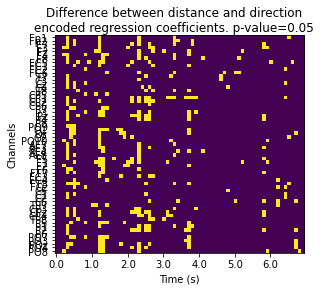

In [8]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_04_16_glm_results_cue_aligned_new_shrinkage_approach', dst_fldr='2023_04_16_glm_results_cue_aligned_new_shrinkage_approach')

clas.plot_heatmap_of_regr_coeff(src=src_path, dst=dst_path, p_crit=0.05)

## 5.2. Movement-aligned

In [12]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_movement_aligned', dst_fldr='2023_03_22_glm_results_movement_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Fitting GLM movement-aligned for subject {subject}')

    clas.glm(src=src_path, dst=dst_path, sbj=subject)


print(f'Finished with GLM, took me {round(time.time() - start)} seconds...')

Fitting GLM movement-aligned for subject A01
Shrinkege param: 0.00651579073900898
Fitting GLM movement-aligned for subject A02
Shrinkege param: 0.005345673470727013
Fitting GLM movement-aligned for subject A03
Shrinkege param: 0.005967566762998921
Fitting GLM movement-aligned for subject A04
Shrinkege param: 0.005361782453905875
Fitting GLM movement-aligned for subject A05
Shrinkege param: 0.007549102903693336
Fitting GLM movement-aligned for subject A06
Shrinkege param: 0.0059287792854986286
Fitting GLM movement-aligned for subject A07
Shrinkege param: 0.006096637716504805
Fitting GLM movement-aligned for subject A08
Shrinkege param: 0.0060972971930012484
Fitting GLM movement-aligned for subject A09
Shrinkege param: 0.005455423239377814
Fitting GLM movement-aligned for subject A10
Shrinkege param: 0.0059851322208864
Finished with GLM, took me 18 seconds...


In [19]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_glm_results_movement_aligned', dst_fldr='2023_03_22_glm_results_movement_aligned')

clas.coefficient_testing(src=src_path, dst=dst_path, sbj_list=subjects, two_sample=False)

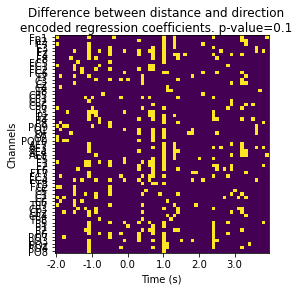

In [14]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_glm_results_movement_aligned', dst_fldr='2023_03_22_glm_results_movement_aligned')

clas.plot_heatmap_of_regr_coeff(src=src_path, dst=dst_path, p_crit=0.1)

# 6. Confusion matrices

# 6.1. Cue algined

In [20]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_cue_aligned', dst_fldr='2023_04_12_classification_figs')

ts_list_dist = [2.4, 2.3, 2.6, 2.1, 2.3, 2.2, 2.4, 2.3, 2.3, 2.4]
# ts_list_dir = [2.9, 2.3, 2.4, 2.3, 2.6, 2.6, 2.7, 2.6, 2.3, 2.4]
ts_list_dir = [2.9, 2.4, 2.1, 2.6, 2.3, 2.2, 2.4, 2.4, 2.2, 2.4]

# clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts_list_dist, n_timepoints=1, condition='distance')

clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts_list_dir, n_timepoints=1, condition='direction')

# clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts, n_timepoints=6, condition='distance')

# clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts_list_dir, n_timepoints=1, condition='direction')


# Mapping: 0-up, 1-down, 2-right, 3-left

29
(175,)
(175,)
24
(177,)
(177,)
21
(162,)
(162,)
26
(169,)
(169,)
23
(146,)
(146,)
22
(173,)
(173,)
24
(180,)
(180,)
24
(150,)
(150,)
22
(157,)
(157,)
24
(162,)
(162,)


C:\Users\peter\Documents\Code\master-thesis\03_analysis\custom_modules\classification_ptu.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
C:\Users\peter\Documents\Code\master-thesis\03_analysis\custom_modules\classification_ptu.py:204: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


# 6.2. Movement aligned

In [23]:
importlib.reload(clas)

# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_movement_aligned', dst_fldr='classification_figs')

ts_list_dist = [0.6, 0.8, 0.6, 1.1, 0.4, 1.1, 1.0, 0.7, 0.4, 0.3]
ts_list_dir = [0.0, 0.2, 0.4, 0.3, 0.2, 0.4, 0.5, 0.2, 0.2, 0.3]



clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts_list_dist, n_timepoints=1, condition='distance')

clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts_list_dir, n_timepoints=1, condition='direction')

# clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts, n_timepoints=6, condition='distance')

# clas.get_confusion_matrix(src=src_path, dst=dst_path, sbj_list=subjects, ts_of_interest=ts, n_timepoints=6, condition='direction')



31
(350,)
(350,)
33
(357,)
(357,)
31
(324,)
(324,)
36
(342,)
(342,)
29
(258,)
(258,)
36
(351,)
(351,)
35
(356,)
(356,)
32
(309,)
(309,)
24
(218,)
(218,)
28
(318,)
(318,)


C:\Users\peter\Documents\Code\master-thesis\03_analysis\custom_modules\classification_ptu.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.clf()
C:\Users\peter\Documents\Code\master-thesis\03_analysis\custom_modules\classification_ptu.py:204: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.close()


25
(174,)
(174,)
27
(180,)
(180,)
29
(159,)
(159,)
28
(171,)
(171,)
27
(131,)
(131,)
29
(175,)
(175,)
30
(176,)
(176,)
27
(163,)
(163,)
22
(114,)
(114,)
28
(161,)
(161,)


C:\Users\peter\Documents\Code\master-thesis\03_analysis\custom_modules\classification_ptu.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.clf()
C:\Users\peter\Documents\Code\master-thesis\03_analysis\custom_modules\classification_ptu.py:204: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.close()


# 7. Experimental single  channel classification

In [3]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='2023_03_22_epoched_cue_aligned', dst_fldr='2023_03_22_epoched_cue_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(subjects):
    print(f'Classifying cue-aligned for subject {subject}')

    ### Distance
    # Classify the epochs for 1 timepoint:
    clas.classify_single_channel(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=1)

print(f'Finished classifying, took me {round(time.time() - start)} seconds...')


Classifying cue-aligned for subject A01
Measuring timestamp 70/70259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)(259, 1)

# Helper cell to add 'Condition' column to the classification dataframe
Outdated, already added to custom_modules/classification_ptu.py.

In [ ]:
# But first add condition to the dataframe as a helper cell:
cond_1 = ['distance'] * 70
cond_2 = ['distance'] * 65
cond_3 = ['direction'] * 70
cond_4 = ['direction'] * 65
cond_5 = ['direction_short'] * 70
cond_6 = ['direction_short'] * 65
cond_7 = ['direction_long'] * 70
cond_8 = ['direction_long'] * 65

cue_cond = cond_1 + cond_2 + cond_3 + cond_4 + cond_5 + cond_6 + cond_7 + cond_8

cue_cond = cue_cond * 10

cond_9 = ['distance'] * 55
cond_10 = ['distance'] * 50
cond_11 = ['direction'] * 55
cond_12 = ['direction'] * 50
cond_13 = ['direction_short'] * 55
cond_14 = ['direction_short'] * 50
cond_15 = ['direction_long'] * 55
cond_16 = ['direction_long'] * 50

mov_cond = cond_9 + cond_10 + cond_11 + cond_12 + cond_13 + cond_14 + cond_15 + cond_16
mov_cond = mov_cond * 10
conds = cue_cond + mov_cond

df = pd.read_csv('dataframes/classification/classification_df.csv', index_col=0)
df['Condition'] = conds

In [ ]:
df.to_csv('dataframes/classification/classification_df.csv')

# T-SNE experimental

In [6]:
from sklearn import manifold

In [ ]:
n_components = 2

In [ ]:
# Get data:


In [ ]:
t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)


In [ ]:
S_t_sne = t_sne.fit_transform(S_points)

plot_2d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")